## Libreta de pruebas para matriz de correlación

In [4]:
import pyreadr as py
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.python.keras.callbacks import TensorBoard
import tensorflow as tf
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,Normalizer
from tensorflow import keras
import keras_tuner as kt
import tensorflow as tf
import os
from sklearn.preprocessing import OneHotEncoder

In [5]:
def plot_confusion_matrix(test_y, predict_y):
    # Convertir las probabilidades predichas en clases
    print(predict_y.shape)
    print(test_y.shape)
    #if len(predict_y.shape) == 1:
    #    predict_y_classes = predict_y.reshape(-1, 1)
    #else:
    #    predict_y_classes = np.argmax(predict_y, axis=1)
    
    # Calcular la matriz de confusión
    C = confusion_matrix(test_y, predict_y_classes)
    
    # Calcular la precisión y recall
    A = (((C.T) / (C.sum(axis=1))).T)
    B = (C / C.sum(axis=0))
    
    labels = [0,1,2,4,5,6,7,8,10,11,12,13,14,16,17,18,19,20]
    cmap = sns.light_palette("green")
    
    # Representar la matriz de confusión en formato de heatmap
    print("-" * 50, "Confusion matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # Representar la matriz de precisión en formato de heatmap
    print("-" * 50, "Precision matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # Representar la matriz de recall en formato de heatmap
    print("-" * 50, "Recall matrix", "-" * 50)
    plt.figure(figsize=(20,20))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))


In [6]:
#Read data
train = pd.read_csv('train.csv')
cv = pd.read_csv("cv.csv")
test = pd.read_csv("test.csv")

In [7]:
print("Shape of the sampled train data:", train.shape)
print("Shape of the sampled test data:", test.shape)
print("Shape of the sampled CV data:", cv.shape)
print(train)

Shape of the sampled train data: (270400, 56)
Shape of the sampled test data: (104000, 56)
Shape of the sampled CV data: (106400, 56)
        Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0                0          0.0            1.0       1  0.25038   3674.0   
1                1          0.0            1.0       2  0.25109   3659.4   
2                2          0.0            1.0       3  0.25038   3660.3   
3                3          0.0            1.0       4  0.24977   3661.3   
4                4          0.0            1.0       5  0.29405   3679.0   
...            ...          ...            ...     ...      ...      ...   
270395      239995         20.0           24.0     496  0.28437   3645.3   
270396      239996         20.0           24.0     497  0.27925   3687.0   
270397      239997         20.0           24.0     498  0.27898   3671.8   
270398      239998         20.0           24.0     499  0.26937   3691.9   
270399      239999         20.

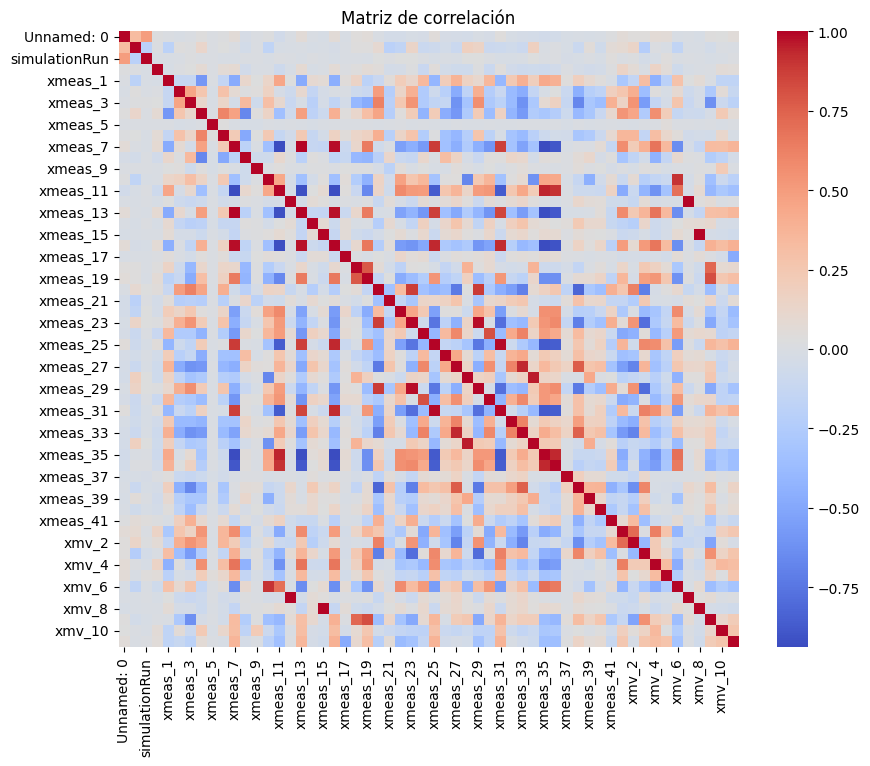

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el conjunto de datos TEP
# Supongamos que tienes un DataFrame llamado 'df' que contiene tus datos
# Reemplaza 'df' con el nombre de tu DataFrame
# Por ejemplo, df = pd.read_csv('archivo.csv')
# O df = tu_data_frame
# df = ...

# Calcular la matriz de correlación
correlation_matrix = train.corr()

# Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()


A simple vista podemos ver qe hay características que tienen bastante correlación con otras. Debido a esto vamos a realizar el mismo proceso que antes pero ahora entrenaremos el modelo con las características que tengan una corrlación menor del $90%$ para ver si así las PDP nos muestran un comportamiento que podamos interpretar de una forma más correcta.

Para ello vamos a sacar todos los pares correlacionados y vamos a eliminar una de las características y así evitar esa correlación. Para eliminar el numero mínimo de características y así alterar lo mínimo posible el modelo eliminaremos aquellas que más correlación tengan con otras (antes que otra que solo tenga correlación con una) porque sino al final quedarían eliminadas ambas características y perderíamos información.

In [7]:
threshold=0.9

# Obtener los pares de columnas correlacionadas
correlated_pairs = (correlation_matrix.abs() > threshold).stack()

# Filtrar los pares correlacionados
correlated_pairs = correlated_pairs[correlated_pairs].index.tolist()

# Convertir los índices de los pares en una lista de tuplas de columnas correlacionadas
correlated_columns_pairs = [(pair[0], pair[1]) for pair in correlated_pairs if pair[0] != pair[1]]

print("Pares de columnas correlacionadas (sin los que están correlacionadas consigo mismos):")
for pair in correlated_columns_pairs:
    print(pair)


# Obtener las entradas únicas de la primera columna en los pares
unique_entries = sorted(set(pair[0] for pair in correlated_columns_pairs))
print("Entradas únicas de la primera columna en los pares correlacionados:")
print(unique_entries)

Pares de columnas correlacionadas (sin los que están correlacionadas consigo mismos):
('xmeas_7', 'xmeas_11')
('xmeas_7', 'xmeas_13')
('xmeas_7', 'xmeas_16')
('xmeas_7', 'xmeas_35')
('xmeas_10', 'xmv_6')
('xmeas_11', 'xmeas_7')
('xmeas_11', 'xmeas_13')
('xmeas_11', 'xmeas_16')
('xmeas_11', 'xmeas_35')
('xmeas_11', 'xmeas_36')
('xmeas_12', 'xmv_7')
('xmeas_13', 'xmeas_7')
('xmeas_13', 'xmeas_11')
('xmeas_13', 'xmeas_16')
('xmeas_13', 'xmeas_35')
('xmeas_15', 'xmv_8')
('xmeas_16', 'xmeas_7')
('xmeas_16', 'xmeas_11')
('xmeas_16', 'xmeas_13')
('xmeas_16', 'xmeas_25')
('xmeas_16', 'xmeas_31')
('xmeas_16', 'xmeas_35')
('xmeas_16', 'xmeas_36')
('xmeas_23', 'xmeas_29')
('xmeas_25', 'xmeas_16')
('xmeas_25', 'xmeas_31')
('xmeas_27', 'xmeas_33')
('xmeas_28', 'xmeas_34')
('xmeas_29', 'xmeas_23')
('xmeas_31', 'xmeas_16')
('xmeas_31', 'xmeas_25')
('xmeas_33', 'xmeas_27')
('xmeas_34', 'xmeas_28')
('xmeas_35', 'xmeas_7')
('xmeas_35', 'xmeas_11')
('xmeas_35', 'xmeas_13')
('xmeas_35', 'xmeas_16')
('xmea

Vamos a eliminar las features que están correlacionadas y entrenar el modelo para observar como se compotan las dependencias parciales.

Para ello vamos a eliminar las siguientes características:
xmeas_10, xmeas_11, xmeas_12, xmeas_13, xmeas_15, xmeas_16, xmeas_23, xmeas_25, xmeas_27, xmeas_28, xmeas_29, xmeas_31, xmeas_33, xmeas_34, xmeas_35, xmeas_36, xmeas_7, xmv_6, xmv_7, xmv_8


In [8]:
# Removing faults 3,9 and 15 
tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15)].index).reset_index()
cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15)].index).reset_index()


In [9]:
print(train)
# Resizing the train, test and cv data.
x_train = np.resize(tr,(183200,52,1))
x_test = np.resize(ts,(89000,52,1))
x_cv = np.resize(cv_,(93440,52,1))

        Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0                0          0.0            1.0       1  0.25038   3674.0   
1                1          0.0            1.0       2  0.25109   3659.4   
2                2          0.0            1.0       3  0.25038   3660.3   
3                3          0.0            1.0       4  0.24977   3661.3   
4                4          0.0            1.0       5  0.29405   3679.0   
...            ...          ...            ...     ...      ...      ...   
270395      239995         20.0           24.0     496  0.28437   3645.3   
270396      239996         20.0           24.0     497  0.27925   3687.0   
270397      239997         20.0           24.0     498  0.27898   3671.8   
270398      239998         20.0           24.0     499  0.26937   3691.9   
270399      239999         20.0           24.0     500  0.26889   3680.8   

        xmeas_3  xmeas_4  xmeas_5  xmeas_6  ...   xmv_2   xmv_3   xmv_4  \
0        452

In [10]:
#converting the class labels to categorical values and removing unnecessary features from train, test and cv data.
y_train = tr['faultNumber']
y_test = ts['faultNumber']
y_cv = cv_['faultNumber']


encoder = OneHotEncoder()

# Ajustar y transformar los datos de salida
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_encoded = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
y_cv_encoded = encoder.fit_transform(np.array(y_cv).reshape(-1, 1))




In [11]:
tr.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index','xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_15', 'xmeas_16', 'xmeas_23', 'xmeas_25', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_31', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_7', 'xmv_6', 'xmv_7', 'xmv_8'],axis=1,inplace=True)
ts.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_15', 'xmeas_16', 'xmeas_23', 'xmeas_25', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_31', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_7', 'xmv_6', 'xmv_7', 'xmv_8'],axis =1,inplace=True)
cv_.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_15', 'xmeas_16', 'xmeas_23', 'xmeas_25', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_31', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_7', 'xmv_6', 'xmv_7', 'xmv_8'],axis =1,inplace=True)
standard_scalar = StandardScaler()
train_norm = standard_scalar.fit_transform(tr)
test_norm = standard_scalar.transform(ts)
cv_norm = standard_scalar.transform(cv_)

In [12]:
tr

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_8,xmeas_9,xmeas_14,xmeas_17,...,xmeas_40,xmeas_41,xmv_1,xmv_2,xmv_3,xmv_4,xmv_5,xmv_9,xmv_10,xmv_11
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,74.863,120.41,25.029,22.819,...,53.724,43.828,62.881,53.744,24.657,62.544,22.137,47.510,41.258,18.447
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,75.000,120.41,24.419,23.333,...,53.724,43.828,63.132,53.414,24.588,59.259,22.084,47.427,41.359,17.194
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,74.771,120.42,25.244,21.924,...,53.724,43.828,63.117,54.357,24.666,61.275,22.380,47.468,41.199,20.530
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,75.224,120.39,23.268,22.948,...,53.724,43.828,63.100,53.946,24.725,59.856,22.277,47.658,41.643,18.089
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,75.388,120.39,26.099,22.808,...,53.724,43.828,63.313,53.658,28.797,60.717,21.947,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235835,0.28437,3645.3,4476.8,9.3158,27.041,42.017,74.217,120.41,24.668,22.379,...,53.842,44.153,63.581,53.831,27.820,58.953,19.810,49.613,42.208,19.711
235836,0.27925,3687.0,4471.1,9.2843,26.594,41.935,74.513,120.39,27.534,23.482,...,53.842,44.153,63.320,52.904,27.161,61.933,19.796,49.616,40.490,17.089
235837,0.27898,3671.8,4453.8,9.2279,26.427,42.475,74.098,120.42,25.033,23.109,...,53.842,44.153,63.581,53.112,27.188,62.026,19.764,49.824,41.805,17.934
235838,0.26937,3691.9,4495.6,9.3308,26.934,42.480,75.163,120.39,25.598,22.824,...,53.842,44.153,62.918,53.451,26.270,59.054,20.009,49.782,40.466,18.613


In [13]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Define tu modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(32,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(train_norm, y_train_encoded.toarray(), epochs=10, validation_data=(cv_norm, y_cv_encoded.toarray()))

# Evalúa el modelo
accuracy = model.evaluate(test_norm, y_test_encoded.toarray())[1]
print("Accuracy:", accuracy)


/home/inmamzm/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-23 19:19:53.078864: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 19:19:53.078993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-

Epoch 1/10


L355
2024-04-23 19:19:53.104788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 19:19:53.104864: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 19:19:53.266601: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

 238/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 638us/step - accuracy: 0.2393 - loss: 2.5995

I0000 00:00:1713892794.928996  488579 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7370/7370 ━━━━━━━━━━━━━━━━━━━━ 7s 828us/step - accuracy: 0.6517 - loss: 1.1768 - val_accuracy: 0.8250 - val_loss: 0.7665
Epoch 2/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 807us/step - accuracy: 0.8394 - loss: 0.5336 - val_accuracy: 0.8698 - val_loss: 0.6450
Epoch 3/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 791us/step - accuracy: 0.8796 - loss: 0.4198 - val_accuracy: 0.8908 - val_loss: 0.8218
Epoch 4/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 810us/step - accuracy: 0.9023 - loss: 0.3553 - val_accuracy: 0.9083 - val_loss: 0.7297
Epoch 5/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 10s 807us/step - accuracy: 0.9133 - loss: 0.3191 - val_accuracy: 0.9140 - val_loss: 0.7660
Epoch 6/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 814us/step - accuracy: 0.9173 - loss: 0.3033 - val_accuracy: 0.9128 - val_loss: 0.9267
Epoch 7/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 814us/step - accuracy: 0.9208 - loss: 0.2924 - val_accuracy: 0.9161 - val_loss: 0.8822
Epoch 8/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 806us/step - accuracy: 0.9223 - loss: 0.2

2782/2782 ━━━━━━━━━━━━━━━━━━━━ 2s 513us/step
(89000,)
(89000,)
-------------------------------------------------- Confusion matrix --------------------------------------------------


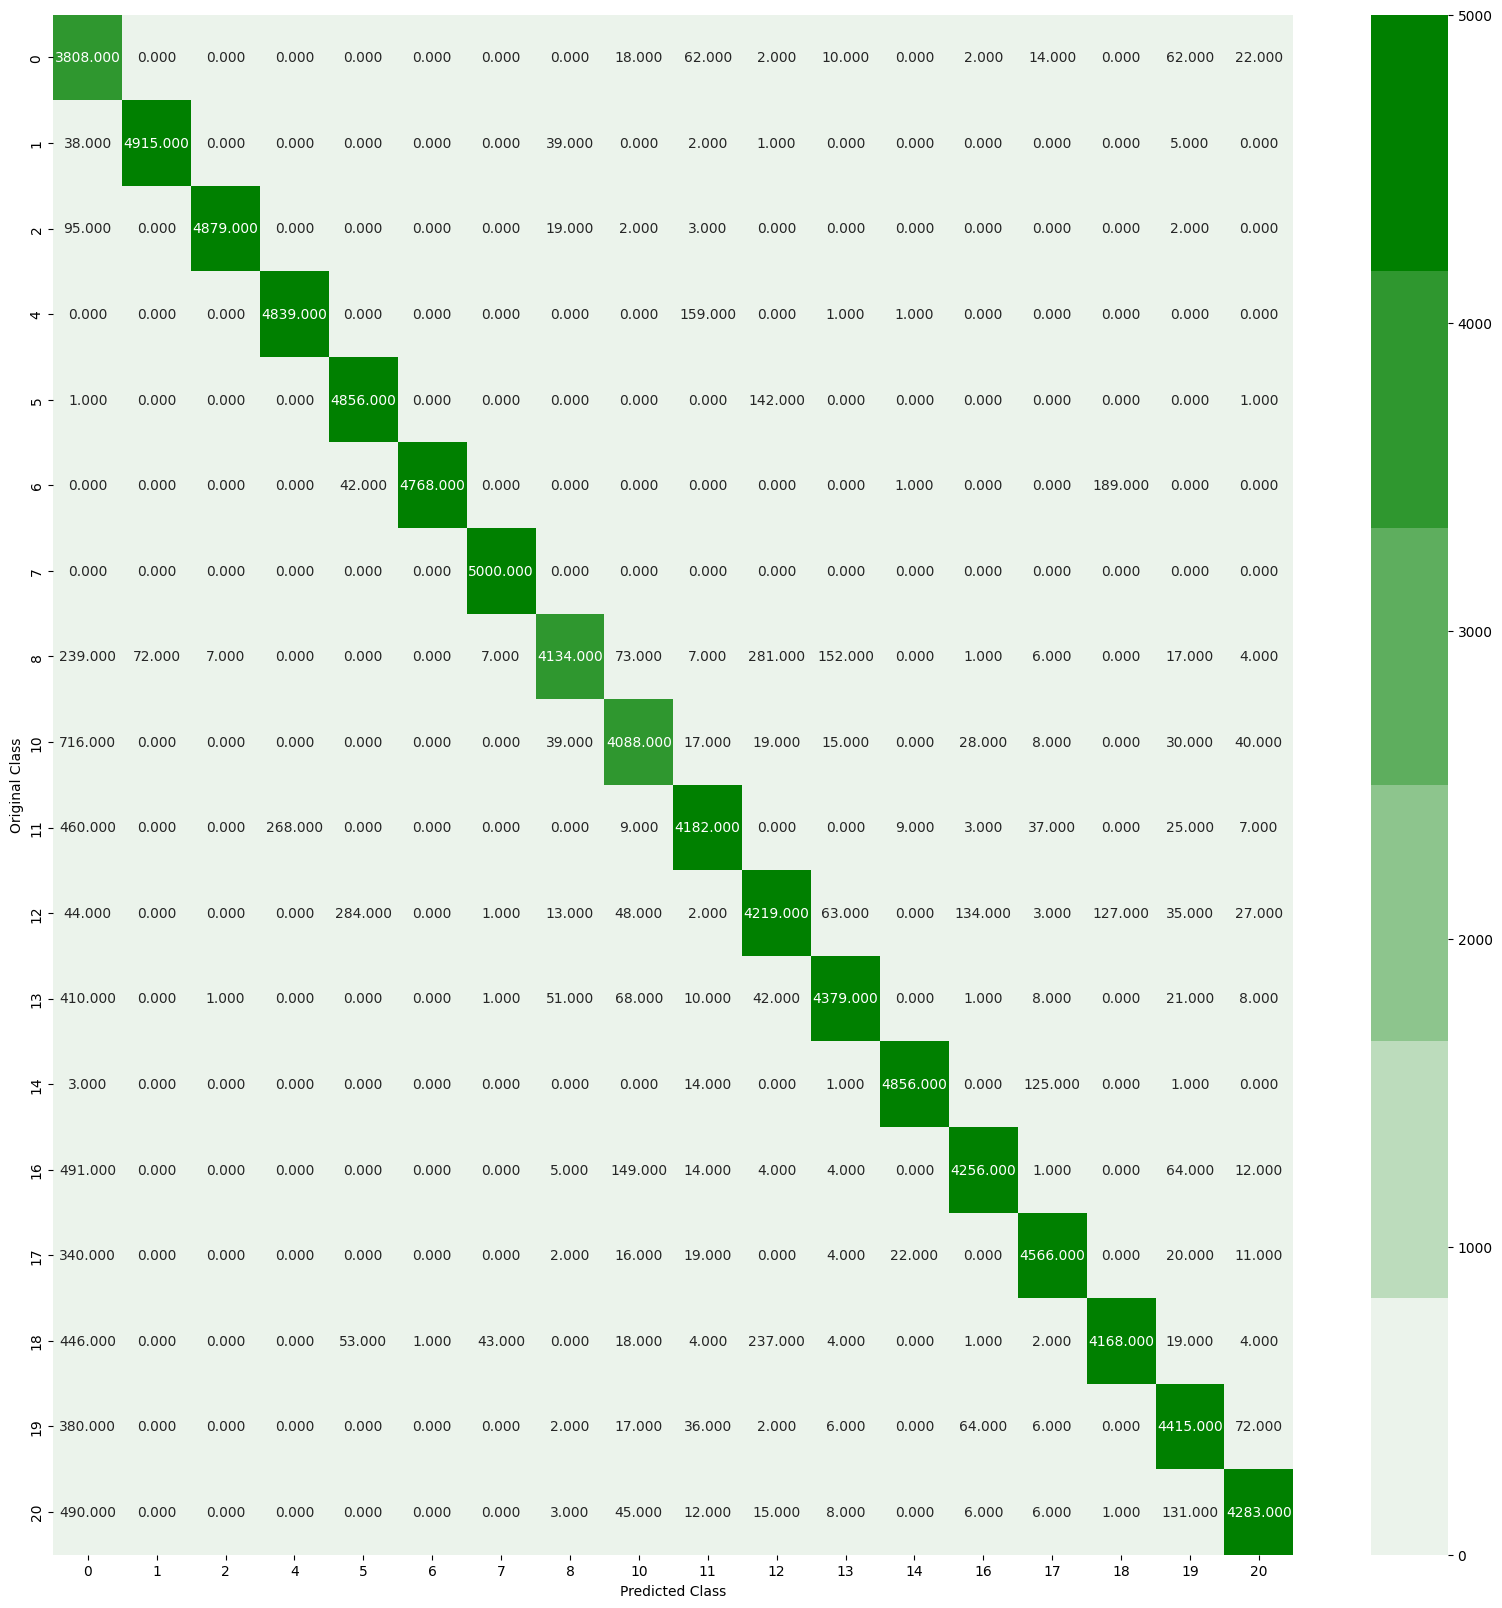

-------------------------------------------------- Precision matrix --------------------------------------------------


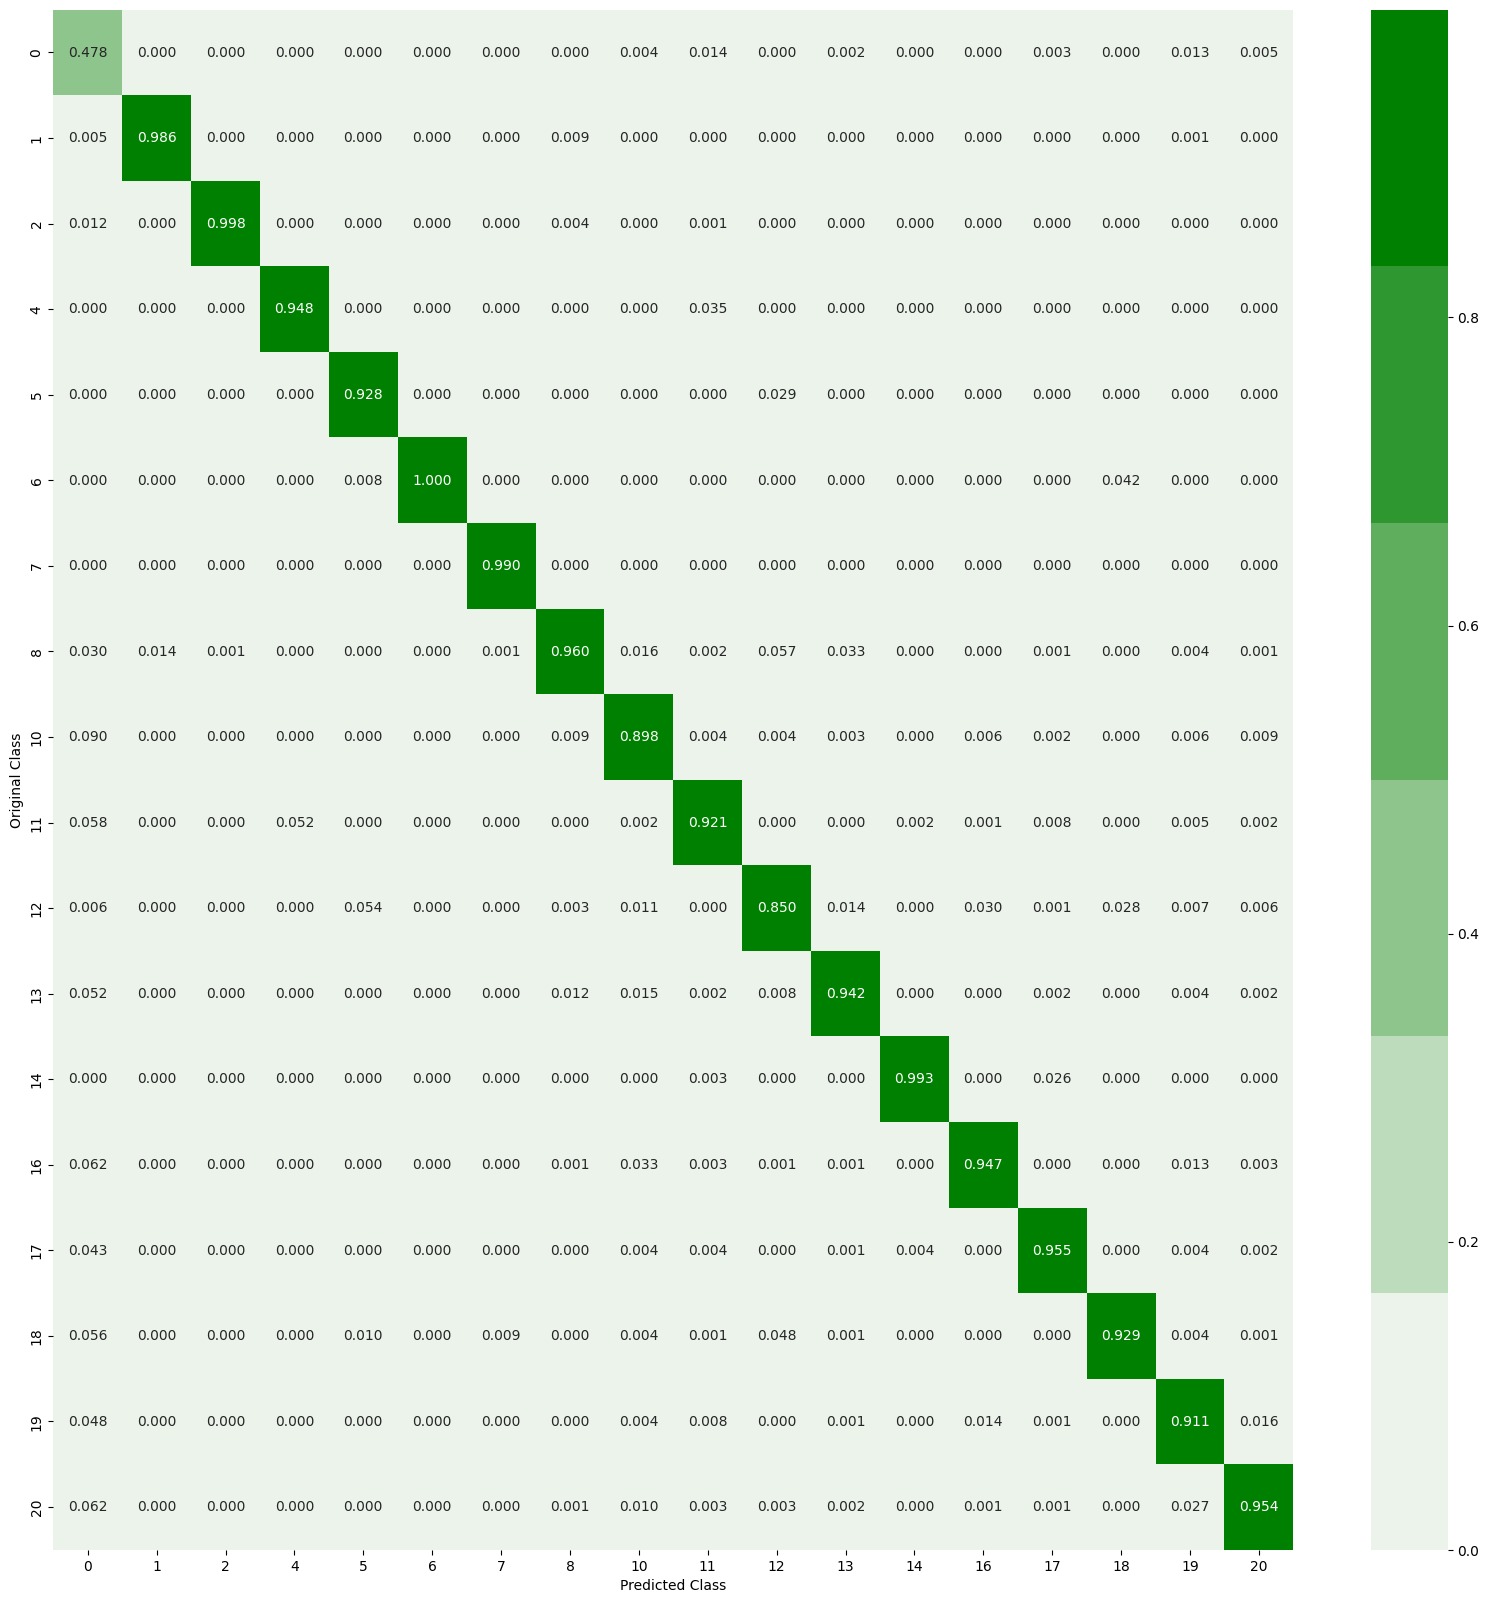

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


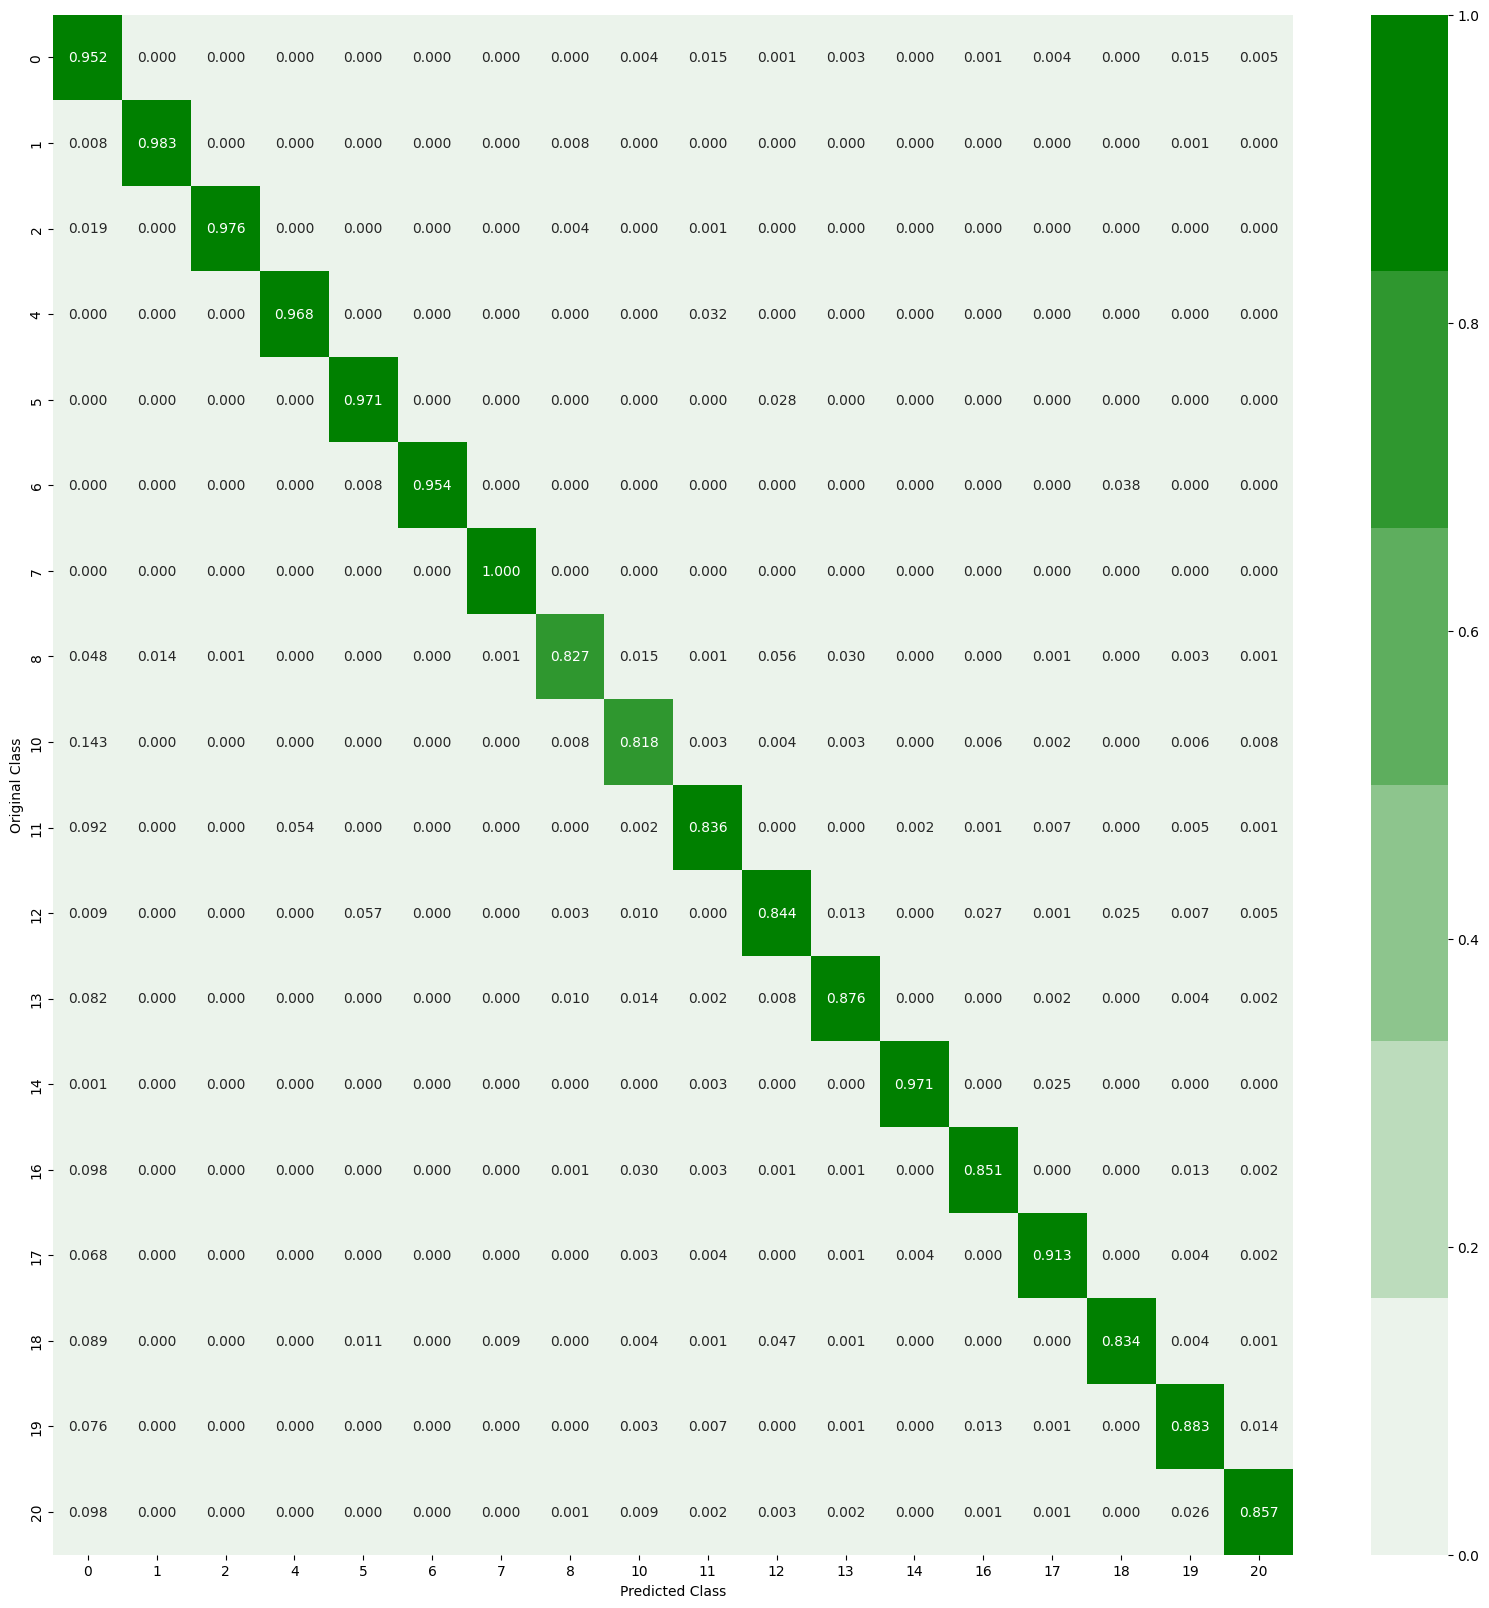

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

# Obtener las probabilidades predichas del modelo
predict_y_prob = model.predict(test_norm)

# Convertir las probabilidades predichas en clases
predict_y_classes = np.argmax(predict_y_prob, axis=1)

predict_y_multilabel = np.argmax(predict_y_prob, axis=1)

# Convertir las clases predichas a un formato multilabel-indicator
#predict_y_multilabel = label_binarize(predict_y_classes, classes=np.unique(y_test_encoded))

# Llamar a la función plot_confusion_matrix con las etiquetas verdaderas y las predicciones
plot_confusion_matrix(np.argmax(y_test_encoded.toarray(), axis=1), predict_y_classes)


### Partial Dependence Plot (PDP)

In [17]:
import shap

Grafica de 0
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 475us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 477us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 506us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 481us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 502us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/st

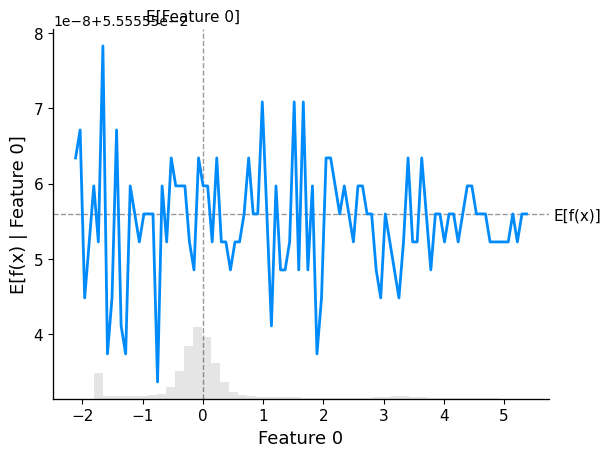

Grafica de 1
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 502us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 512us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 470us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 498us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 493us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 493us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/st

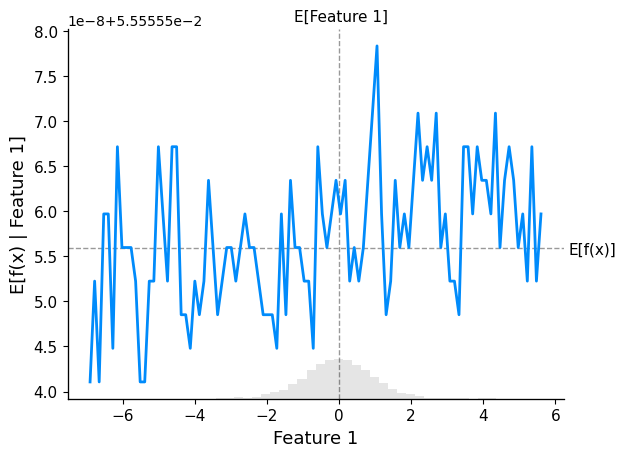

Grafica de 2
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 493us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 511us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 506us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 530us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 482us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 464us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/st

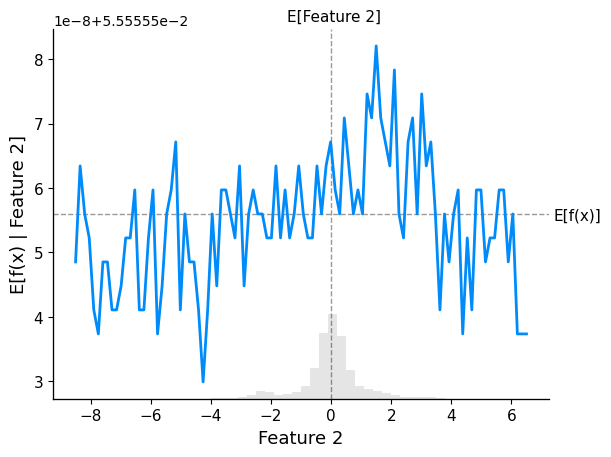

Grafica de 3
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
6753/7370 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step

KeyboardInterrupt: 

In [16]:
for i in range(0, 32):
    print('Grafica de', i)
    shap.plots.partial_dependence(
    #    i, lambda x: model.predict(x)[0], train_norm, ice=False,
        i, model.predict, train_norm, ice=False,
        model_expected_value=True, feature_expected_value=True
    )

Como podemos observar en las 32 gráficas que hemos pintado, el comportamiento de todas las gráficas es muy similar al caso anterior en el que no eliminabamos ninguna característica correlacionada. Con este resultado tampoco podemos sacar conclusiones que nos permitan interpretar de forma correcta el modelo. 

Podríamos pensar que eliminar solo aquellas que tienen igual o más de un $90%$ de correlación nos deja bastantes caracteríticas todavía correlacionadas entre ellas con un alto $%$. Tras un pequeño análisis de donde poner el threshold hemos decidido dejarlo en un $70%$ puesto que bajarlo más supone eliminar más del $65-70%$ de las características lo que supondría que nuestro modelo no sería nada bueno ya que habríamos eliminado la mayoría de características. De hecho con el threshold al $70%$ ya nos quedamos con 23 características, pero para el proposito de conseguir comprender que está sucediendo en nuestras gráficas con el $100$% de las características nos vale.

#### Ahora vamos a repetir el mismo proceso pero vamos a quitar aquellas features que tengan más de un 70% de correlación

In [9]:
threshold=0.70

# Obtener los pares de columnas correlacionadas
correlated_pairs = (correlation_matrix.abs() > threshold).stack()

# Filtrar los pares correlacionados
correlated_pairs = correlated_pairs[correlated_pairs].index.tolist()

# Convertir los índices de los pares en una lista de tuplas de columnas correlacionadas
correlated_columns_pairs = [(pair[0], pair[1]) for pair in correlated_pairs if pair[0] != pair[1]]

print("Pares de columnas correlacionadas (sin los que están correlacionadas consigo mismos):")
for pair in correlated_columns_pairs:
    print(pair)


# Obtener las entradas únicas de la primera columna en los pares
unique_entries = sorted(set(pair[0] for pair in correlated_columns_pairs))
print("Entradas únicas de la primera columna en los pares correlacionados:")
print(unique_entries)

Pares de columnas correlacionadas (sin los que están correlacionadas consigo mismos):
('xmeas_7', 'xmeas_11')
('xmeas_7', 'xmeas_13')
('xmeas_7', 'xmeas_16')
('xmeas_7', 'xmeas_25')
('xmeas_7', 'xmeas_31')
('xmeas_7', 'xmeas_35')
('xmeas_7', 'xmeas_36')
('xmeas_10', 'xmv_6')
('xmeas_11', 'xmeas_7')
('xmeas_11', 'xmeas_13')
('xmeas_11', 'xmeas_16')
('xmeas_11', 'xmeas_25')
('xmeas_11', 'xmeas_31')
('xmeas_11', 'xmeas_35')
('xmeas_11', 'xmeas_36')
('xmeas_12', 'xmv_7')
('xmeas_13', 'xmeas_7')
('xmeas_13', 'xmeas_11')
('xmeas_13', 'xmeas_16')
('xmeas_13', 'xmeas_25')
('xmeas_13', 'xmeas_31')
('xmeas_13', 'xmeas_35')
('xmeas_13', 'xmeas_36')
('xmeas_15', 'xmv_8')
('xmeas_16', 'xmeas_7')
('xmeas_16', 'xmeas_11')
('xmeas_16', 'xmeas_13')
('xmeas_16', 'xmeas_25')
('xmeas_16', 'xmeas_31')
('xmeas_16', 'xmeas_35')
('xmeas_16', 'xmeas_36')
('xmeas_18', 'xmeas_19')
('xmeas_18', 'xmv_9')
('xmeas_19', 'xmeas_18')
('xmeas_19', 'xmv_9')
('xmeas_20', 'xmeas_23')
('xmeas_20', 'xmeas_27')
('xmeas_20', '

In [10]:
# Removing faults 3,9 and 15 
tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15)].index).reset_index()
cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15)].index).reset_index()


In [11]:
print(train)
# Resizing the train, test and cv data.
x_train = np.resize(tr,(183200,52,1))
x_test = np.resize(ts,(89000,52,1))
x_cv = np.resize(cv_,(93440,52,1))

        Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0                0          0.0            1.0       1  0.25038   3674.0   
1                1          0.0            1.0       2  0.25109   3659.4   
2                2          0.0            1.0       3  0.25038   3660.3   
3                3          0.0            1.0       4  0.24977   3661.3   
4                4          0.0            1.0       5  0.29405   3679.0   
...            ...          ...            ...     ...      ...      ...   
270395      239995         20.0           24.0     496  0.28437   3645.3   
270396      239996         20.0           24.0     497  0.27925   3687.0   
270397      239997         20.0           24.0     498  0.27898   3671.8   
270398      239998         20.0           24.0     499  0.26937   3691.9   
270399      239999         20.0           24.0     500  0.26889   3680.8   

        xmeas_3  xmeas_4  xmeas_5  xmeas_6  ...   xmv_2   xmv_3   xmv_4  \
0        452

In [12]:
#converting the class labels to categorical values and removing unnecessary features from train, test and cv data.
y_train = tr['faultNumber']
y_test = ts['faultNumber']
y_cv = cv_['faultNumber']


encoder = OneHotEncoder()

# Ajustar y transformar los datos de salida
y_train_encoded = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_encoded = encoder.fit_transform(np.array(y_test).reshape(-1, 1))
y_cv_encoded = encoder.fit_transform(np.array(y_cv).reshape(-1, 1))




In [13]:
tr.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index','xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_15', 'xmeas_16', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_38', 'xmeas_7', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9'],axis=1,inplace=True)
ts.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_15', 'xmeas_16', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_38', 'xmeas_7', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9'],axis =1,inplace=True)
cv_.drop(['faultNumber','Unnamed: 0','simulationRun','sample','index', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_15', 'xmeas_16', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_23', 'xmeas_24', 'xmeas_25', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_38', 'xmeas_7', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9'],axis =1,inplace=True)
standard_scalar = StandardScaler()
train_norm = standard_scalar.fit_transform(tr)
test_norm = standard_scalar.transform(ts)
cv_norm = standard_scalar.transform(cv_)

In [14]:
tr

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_8,xmeas_9,xmeas_14,xmeas_17,...,xmeas_26,xmeas_32,xmeas_37,xmeas_39,xmeas_40,xmeas_41,xmv_4,xmv_5,xmv_10,xmv_11
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,74.863,120.41,25.029,22.819,...,6.8820,1.2565,0.017866,0.098577,53.724,43.828,62.544,22.137,41.258,18.447
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,75.000,120.41,24.419,23.333,...,6.8820,1.2565,0.017866,0.098577,53.724,43.828,59.259,22.084,41.359,17.194
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,74.771,120.42,25.244,21.924,...,6.8259,1.3001,0.017866,0.098577,53.724,43.828,61.275,22.380,41.199,20.530
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,75.224,120.39,23.268,22.948,...,6.8259,1.3001,0.017866,0.098577,53.724,43.828,59.856,22.277,41.643,18.089
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,75.388,120.39,26.099,22.808,...,6.8688,1.0938,0.017866,0.098577,53.724,43.828,60.717,21.947,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235835,0.28437,3645.3,4476.8,9.3158,27.041,42.017,74.217,120.41,24.668,22.379,...,6.8068,1.2064,0.018453,0.088404,53.842,44.153,58.953,19.810,42.208,19.711
235836,0.27925,3687.0,4471.1,9.2843,26.594,41.935,74.513,120.39,27.534,23.482,...,6.8488,1.0893,0.018453,0.088404,53.842,44.153,61.933,19.796,40.490,17.089
235837,0.27898,3671.8,4453.8,9.2279,26.427,42.475,74.098,120.42,25.033,23.109,...,6.8488,1.0893,0.018453,0.088404,53.842,44.153,62.026,19.764,41.805,17.934
235838,0.26937,3691.9,4495.6,9.3308,26.934,42.480,75.163,120.39,25.598,22.824,...,6.8508,1.3346,0.018453,0.088404,53.842,44.153,59.054,20.009,40.466,18.613


In [15]:

# Define tu modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(22,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

# Compila el modelo
model.compile(optimizer='adamw', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrena el modelo
history = model.fit(train_norm, y_train_encoded.toarray(), epochs=10, validation_data=(cv_norm, y_cv_encoded.toarray()))

# Evalúa el modelo
accuracy = model.evaluate(test_norm, y_test_encoded.toarray())[1]
print("Accuracy:", accuracy)


/home/inmamzm/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-24 11:04:26.062436: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 11:04:26.062610: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-

Epoch 1/10


L355
2024-04-24 11:04:26.090430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 11:04:26.090564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 11:04:26.262794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

 230/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 656us/step - accuracy: 0.2187 - loss: 2.6570

I0000 00:00:1713949467.844276  563262 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7370/7370 ━━━━━━━━━━━━━━━━━━━━ 8s 921us/step - accuracy: 0.6127 - loss: 1.3014 - val_accuracy: 0.7719 - val_loss: 0.8523
Epoch 2/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 856us/step - accuracy: 0.7761 - loss: 0.7009 - val_accuracy: 0.7856 - val_loss: 0.8210
Epoch 3/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 854us/step - accuracy: 0.7890 - loss: 0.6567 - val_accuracy: 0.7922 - val_loss: 0.7810
Epoch 4/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 856us/step - accuracy: 0.7965 - loss: 0.6302 - val_accuracy: 0.7978 - val_loss: 0.7256
Epoch 5/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 839us/step - accuracy: 0.8005 - loss: 0.6189 - val_accuracy: 0.8017 - val_loss: 0.7679
Epoch 6/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 834us/step - accuracy: 0.8035 - loss: 0.6091 - val_accuracy: 0.8057 - val_loss: 0.7706
Epoch 7/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 843us/step - accuracy: 0.8073 - loss: 0.5961 - val_accuracy: 0.8039 - val_loss: 0.7554
Epoch 8/10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 6s 849us/step - accuracy: 0.8115 - loss: 0.58

PDP - feature  xmeas_1
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 565us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 508us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 508us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 504us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 503us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 502us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 508us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 5s 737us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 493us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4

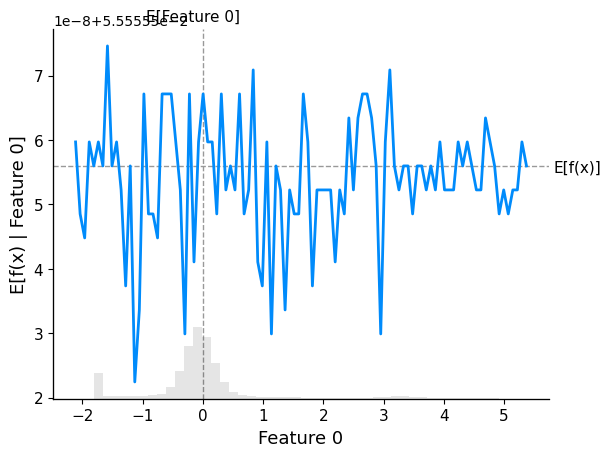

PDP - feature  xmeas_2
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 514us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 503us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 498us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 502us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 514us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 503us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 520us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 528us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 514us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 506us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 514us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4

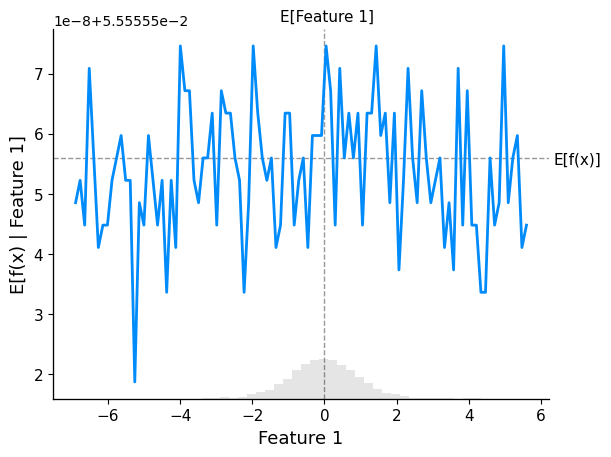

PDP - feature  xmeas_3
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 504us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 502us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 549us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 520us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 545us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 521us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 548us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 568us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 577us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 520us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 553us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 504us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4

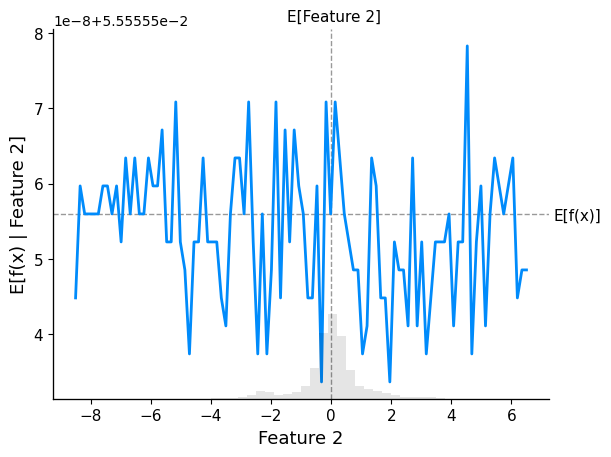

PDP - feature  xmeas_4
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 506us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 529us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 512us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 552us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 562us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 562us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 544us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 548us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 5s 629us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 573us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 511us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 535us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 521us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4

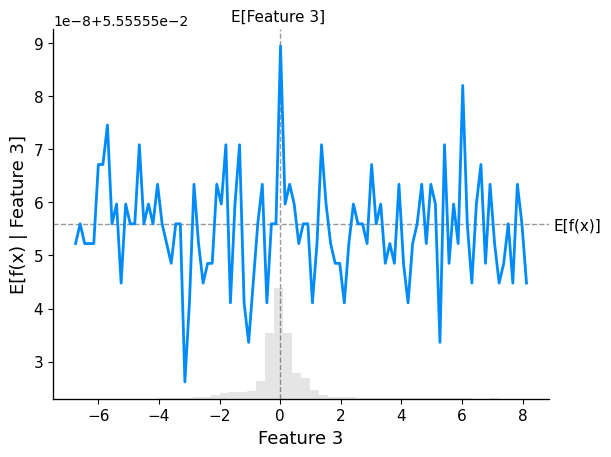

PDP - feature  xmeas_5
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 511us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 530us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 511us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 503us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 511us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 520us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 537us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 545us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 526us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 540us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 530us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 523us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 508us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 521us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4

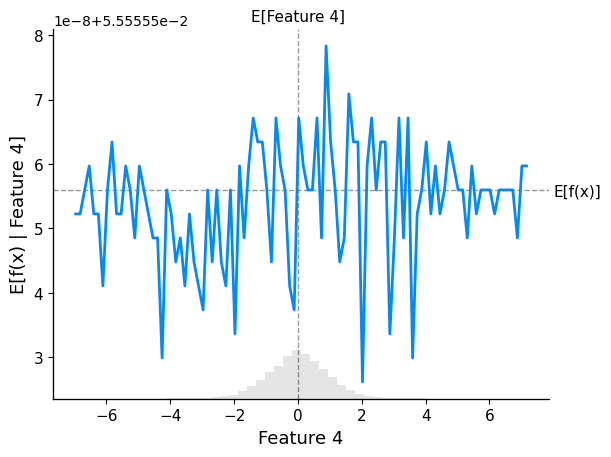

PDP - feature  xmeas_6
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 498us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 506us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 479us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 471us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 549us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 471us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 477us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 466us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 477us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3

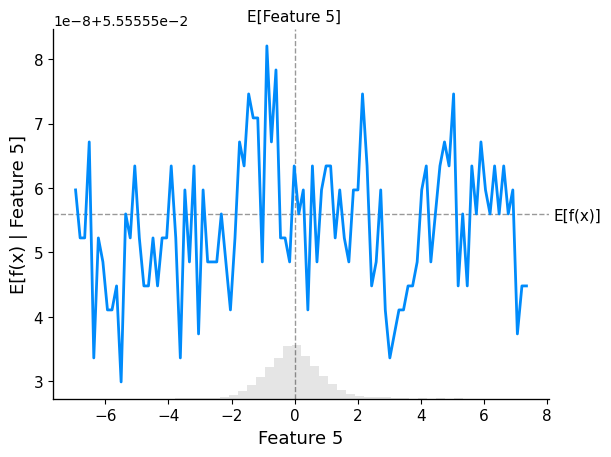

PDP - feature  xmeas_8
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 498us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 487us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 479us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 487us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 511us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4

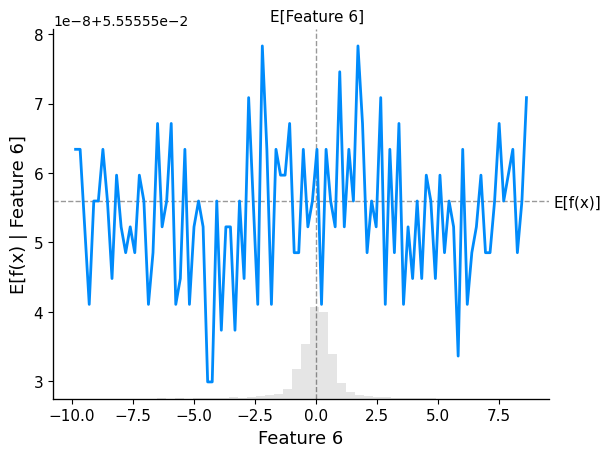

PDP - feature  xmeas_9
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 487us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 482us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 503us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 530us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 579us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 527us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 537us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 599us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 481us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4

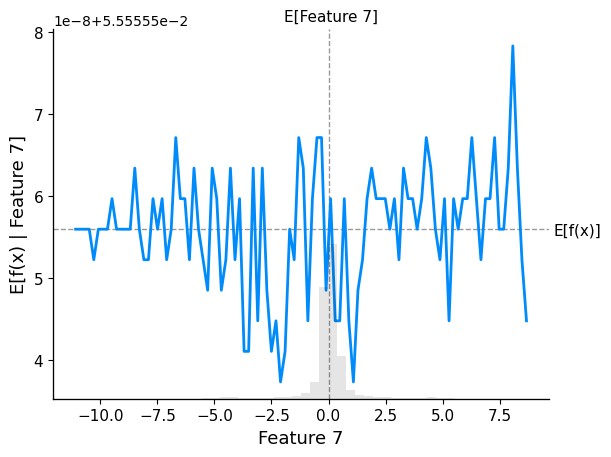

PDP - feature  xmeas_14
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 545us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 565us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 552us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 537us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 5s 614us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 565us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 555us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 539us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 560us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 526us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 502us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 498us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 535us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 502us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 502us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 506us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 

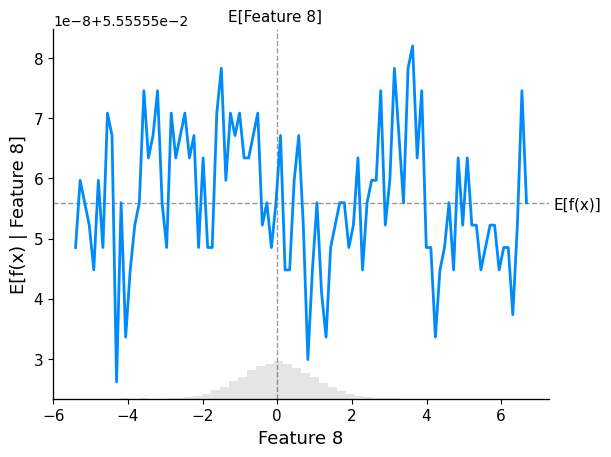

PDP - feature  xmeas_17
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 514us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 473us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 476us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 498us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 477us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 521us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 477us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 478us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 473us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 532us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 

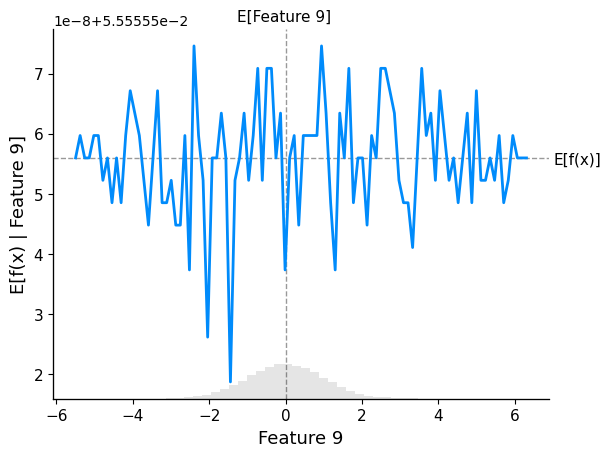

PDP - feature  xmeas_21
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 512us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 506us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 487us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 481us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 481us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 481us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 477us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 506us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 

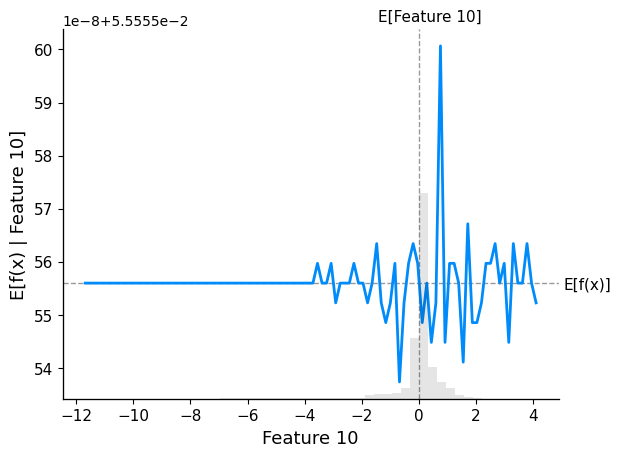

PDP - feature  xmeas_22
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 477us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 563us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 477us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 479us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 477us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 487us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 481us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 481us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 

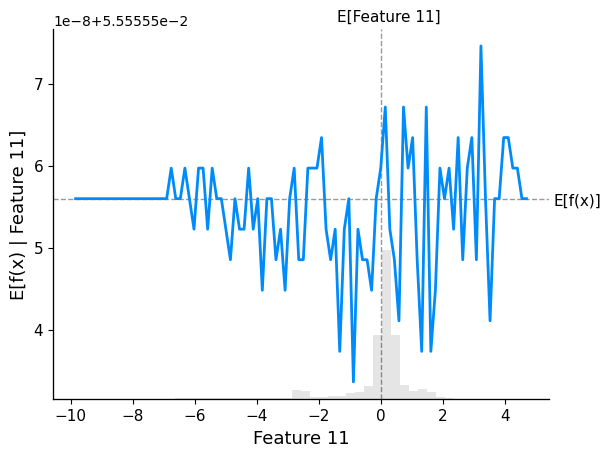

PDP - feature  xmeas_26
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 487us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 477us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 539us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 482us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 478us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 525us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 498us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 503us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 482us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 

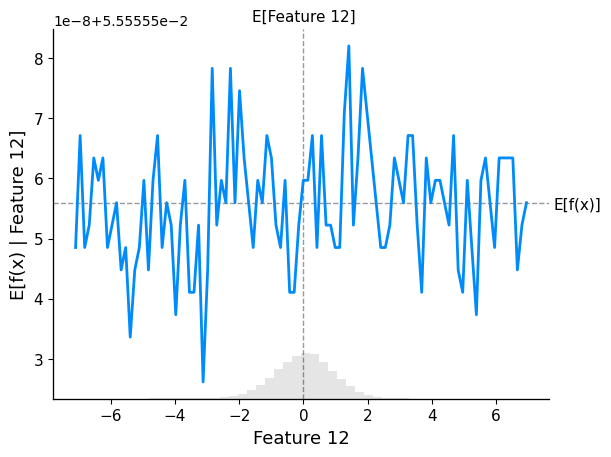

PDP - feature  xmeas_32
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 512us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 474us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 473us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 475us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 476us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 475us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 470us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 

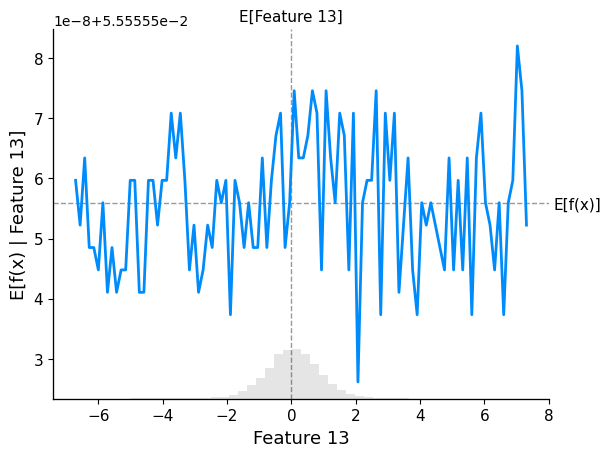

PDP - feature  xmeas_37
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 478us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 493us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 478us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 504us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 504us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 533us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 605us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 

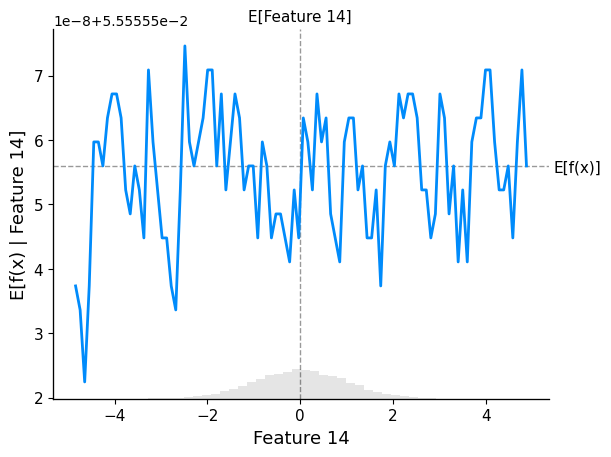

PDP - feature  xmeas_39
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 487us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 487us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 535us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 530us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 

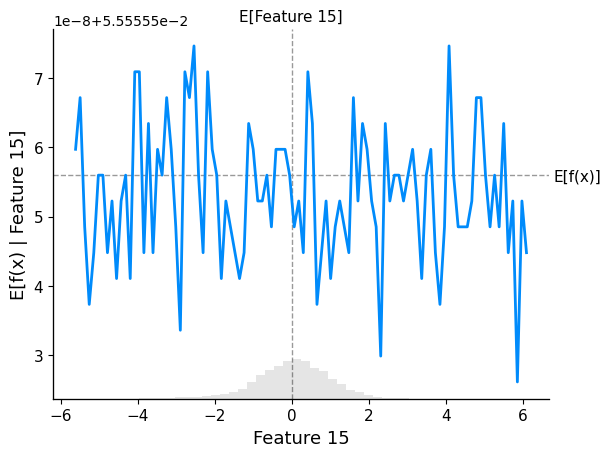

PDP - feature  xmeas_40
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 481us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 537us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 531us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 540us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 508us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 551us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 523us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 538us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 539us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 

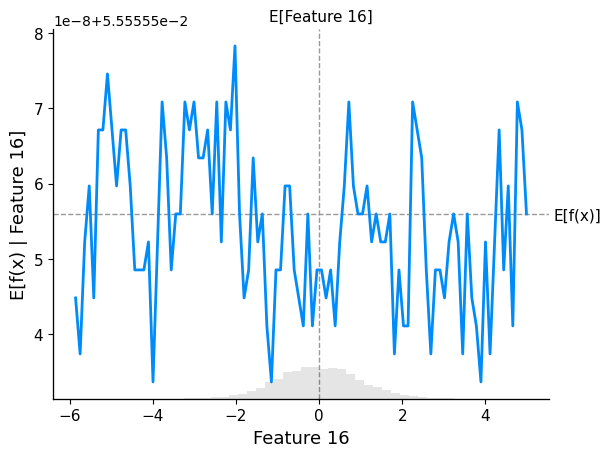

PDP - feature  xmeas_41
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 511us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 602us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 5s 645us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 568us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 562us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 552us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 526us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 578us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 493us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 568us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 525us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 486us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 

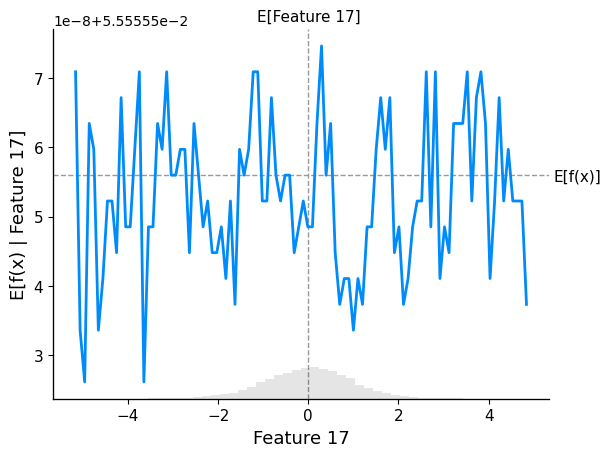

PDP - feature  xmv_4
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 478us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 496us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 471us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 487us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 476us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 3s 465us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 479us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 475us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 490us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 

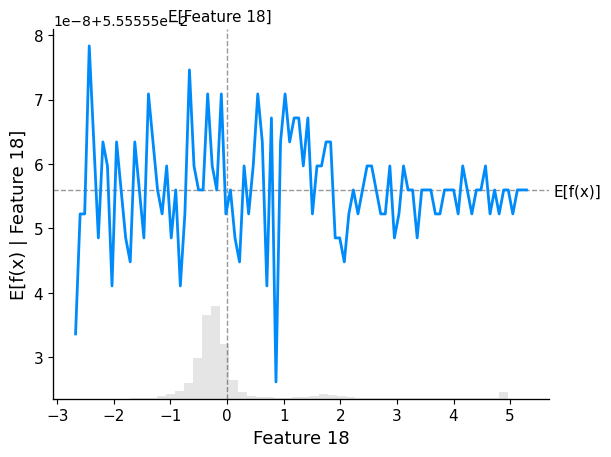

PDP - feature  xmv_5
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 475us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 482us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 493us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 476us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 503us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 507us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 498us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 517us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 502us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 480us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 

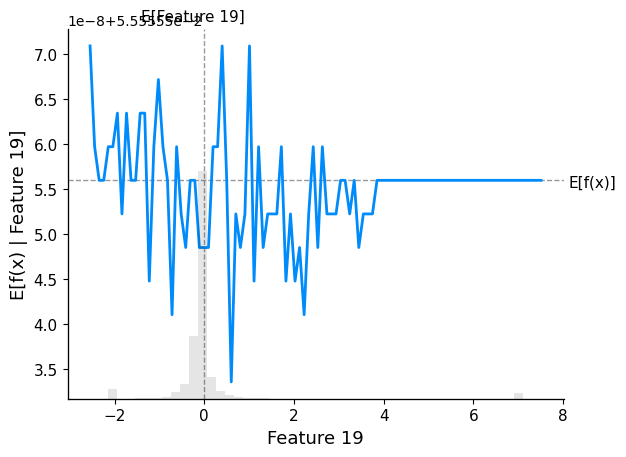

PDP - feature  xmv_10
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 484us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 529us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 500us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 504us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 522us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 529us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 520us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 492us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 524us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 518us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 528us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 495us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 513us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 499us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 502us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 509us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s

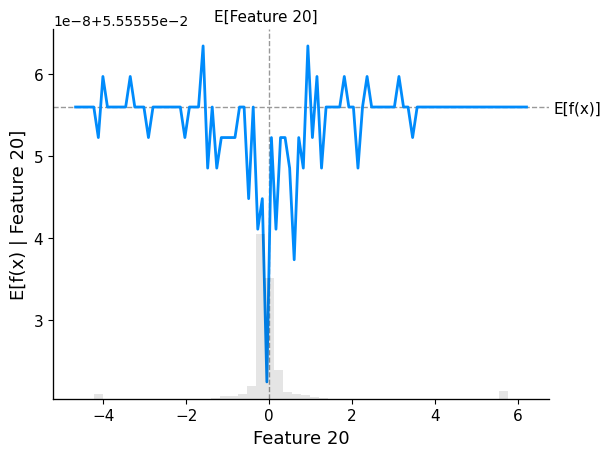

PDP - feature  xmv_11
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 487us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 510us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 476us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 505us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 494us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 498us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 504us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 489us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 491us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 485us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 508us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 512us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 497us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 488us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 519us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 479us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 483us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 526us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s 501us/step
7370/7370 ━━━━━━━━━━━━━━━━━━━━ 4s

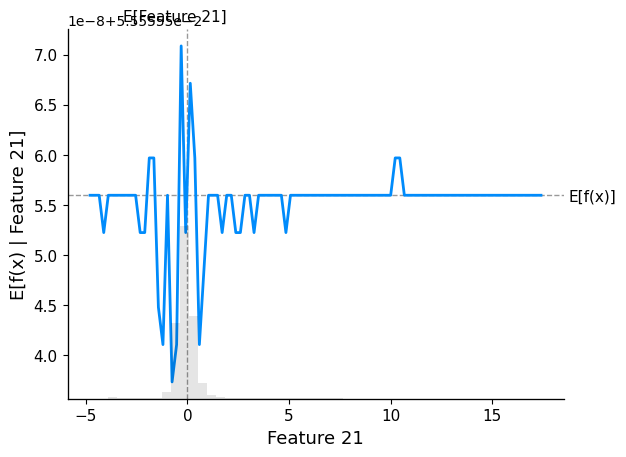

IndexError: list index out of range

In [18]:
list_column=list(tr)
for i in range(0, 22):
    print('PDP - feature ', list_column[i])
    shap.plots.partial_dependence(
    #    i, lambda x: model.predict(x)[0], train_norm, ice=False,
        i, model.predict, train_norm, ice=False,
        model_expected_value=True, feature_expected_value=True
    )

En este caso el resultado vuelve a ser el mismo.

Esto nos indica que a parte de que las características en este modelo están bastante correlacionadas, como hemos podido comprobar en nuestra matriz de correlación, las características son bastante dependientes unas de las otras y por este motivo el uso de PDP no es un buen uso con este conjunto de datos ya que no podemos interpretar de forma correcta los resultados que nos proporciona.